### Import de bibliotecas


In [11]:
# Para os dados
import unicodedata
import string
import sys, random, os

# Para o processamento e análise
import torch
from torch import nn
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

args = {
    'lr': 5e-5,
    'regularizacao': 1e-7,
    'num_epocas': 40,
}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dados de entrada

In [4]:
# comente as duas linhas seguintes caso rode mais de uma vez
!wget  https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #
############################################################

--2022-07-14 20:51:18--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.229.67, 18.65.229.14, 18.65.229.105, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.229.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2022-07-14 20:51:18 (33.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Itali

In [5]:
# Transforma um arquivo de nomes em listas e/ou arrays (nomes, rotulos)
def readLines(filename):
    lines     = open(filename).read().strip().split('\n')
    nomes     = [unicodedata.normalize('NFKD', line).encode('ascii', 'ignore') for line in lines]
    categoria = filename.split('/')[-1].split('.')[0]
    rotulos   = np.repeat( categoria, len(nomes) )

    return nomes, rotulos 


root_path = 'data/names/'
arquivos = sorted(os.listdir(root_path))
categorias = [a[:-4] for a in arquivos]

dados, rotulos = [], []
samples_perclass = []

for file_name in arquivos:
  retorno = readLines(os.path.join(root_path,file_name))
  dados.append(retorno[0])
  rotulos.append(retorno[1])

  samples_perclass.append( (file_name, len(retorno[0])) )


print(samples_perclass, )
print('Minimo amostras', min(samples_perclass, key= lambda k: k[1]), '\n' )

print(dados[categorias.index('Portuguese')][0:10])
print(rotulos[categorias.index('Portuguese')][0:10])

[('Arabic.txt', 2000), ('Chinese.txt', 268), ('Czech.txt', 519), ('Dutch.txt', 297), ('English.txt', 3668), ('French.txt', 277), ('German.txt', 724), ('Greek.txt', 203), ('Irish.txt', 232), ('Italian.txt', 709), ('Japanese.txt', 991), ('Korean.txt', 94), ('Polish.txt', 139), ('Portuguese.txt', 74), ('Russian.txt', 9408), ('Scottish.txt', 100), ('Spanish.txt', 298), ('Vietnamese.txt', 73)]
Minimo amostras ('Vietnamese.txt', 73) 

[b'Abreu', b'Albuquerque', b'Almeida', b'Alves', b'Araujo', b'Araullo', b'Barros', b'Basurto', b'Belo', b'Cabral']
['Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese'
 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese']


### Convertendo os dados para tensor

In [6]:
def label2tensor(rotulos):
  rotulos_tns = torch.zeros( len(rotulos), 1, dtype=torch.int64 )
  for k, rotulo in enumerate(rotulos):
    idx = categorias.index(rotulo)
    rotulos_tns[k][0] = idx
  return rotulos_tns

rotulos_arabe = rotulos[0]
rotulos_tns = label2tensor(rotulos_arabe)
print(type(rotulos_tns), rotulos_arabe[0], rotulos_tns[0])

<class 'torch.Tensor'> Arabic tensor([0])


**Convertendo os nomes para tensor**


In [7]:
caracteres_validos = string.ascii_letters
print(caracteres_validos)
tam_dicionario = len(caracteres_validos)

def nome2tensor(nome):
  tns = torch.zeros( len(nome), tam_dicionario )
  
  for k, letra in enumerate(nome.decode('utf-8')):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1

  return tns

dados_arabe = dados[0]
dados_tns = [nome2tensor(dado) for dado in dados_arabe]
print(dados_arabe[0].decode('utf-8')[0],'\n', dados_tns[0][0])

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
K 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Amostrando batch balanceado**

In [8]:
num_amostras = min(samples_perclass, key= lambda k: k[1])[1]

def sample_batch(size=num_amostras):
  dados_batch, rotulos_batch = [], []
  for cat in categorias:
    
    amostras_cat = dados[categorias.index(cat)]
    idx = np.random.choice(range(len(amostras_cat)), size=size)
    
    dados_batch.extend([ r for k, r in enumerate(dados[categorias.index(cat)]) if k in idx])
    rotulos_batch.extend([ r for k, r in enumerate(rotulos[categorias.index(cat)]) if k in idx])

  dados_tns = [nome2tensor(dado) for dado in dados_batch]
  return dados_tns, label2tensor(rotulos_batch)

dados_batch, rotulos_batch = sample_batch()
print(len(dados_batch), dados_batch[0].size(), rotulos_batch.size())

1139 torch.Size([5, 52]) torch.Size([1139, 1])


In [13]:
import sys
import string

Xtrain, Xtest, Ytrain, Ytest = torch.split(dados_tns, rotulos_tns, test_size=0.2)
print(len(Xtrain), len(Xtest))

TypeError: ignored

In [14]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_feature, tam_saida):
        super(RNN, self).__init__()
        
        self.tam_entrada = tam_entrada
        self.tam_feature = tam_feature
        self.tam_saida   = tam_saida
        
        self.rnn    = nn.RNNCell(self.tam_entrada, self.tam_feature)
        self.linear = nn.Linear(self.tam_feature, self.tam_saida)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, nome):
      
        # Inicialize o estado interno da RNN
        hidden = torch.zeros(1, self.tam_feature).to(args['device'])
        
        for letra in nome:
          letra = letra.unsqueeze(0)
          hidden = self.rnn(letra, hidden)
        
        saida = self.linear(hidden)
        saida = self.softmax(saida) 
        return saida

tam_feature = 256
model = RNN(tam_dicionario, tam_feature, len(categorias))
model.to(args['device'])

RNN(
  (rnn): RNNCell(52, 256)
  (linear): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=None)
)

In [15]:
criterion = nn.NLLLoss().to(args['device']) 
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['regularizacao'])

In [16]:
def forward(X, Y, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for k, (dado, rotulo) in enumerate(zip(X, Y)):
      
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    saida = model(dado)
    loss = criterion(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += 1 if pred[0].item() == rotulo[0].item() else 0

    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(len(loss_epoca))
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [17]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

dados_test, rotulos_test = sample_batch(size=5)
for epoca in range(200):

  dados_tns, rotulos_tns = sample_batch()

  loss, acuracia = forward(dados_tns, rotulos_tns, 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

  loss, acuracia = forward(dados_test, rotulos_test, 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



 ***************Treino***************
Epoca: 0, Loss: 2.6760 +/- 0.6612, Acurácia: 0.1408

 ***************Teste***************
Epoca: 0, Loss: 3.2543 +/- 0.8645, Acurácia: 0.0562

 ***************Treino***************
Epoca: 1, Loss: 2.5482 +/- 0.7784, Acurácia: 0.1423

 ***************Teste***************
Epoca: 1, Loss: 3.3481 +/- 1.0291, Acurácia: 0.0337

 ***************Treino***************
Epoca: 2, Loss: 2.5919 +/- 0.7306, Acurácia: 0.1237

 ***************Teste***************
Epoca: 2, Loss: 3.1610 +/- 0.9239, Acurácia: 0.0674

 ***************Treino***************
Epoca: 3, Loss: 2.5653 +/- 0.6604, Acurácia: 0.1252

 ***************Teste***************
Epoca: 3, Loss: 3.1474 +/- 0.9084, Acurácia: 0.0449

 ***************Treino***************
Epoca: 4, Loss: 2.4547 +/- 0.7010, Acurácia: 0.1470

 ***************Teste***************
Epoca: 4, Loss: 3.1584 +/- 0.9609, Acurácia: 0.0899

 ***************Treino***************
Epoca: 5, Loss: 2.3887 +/- 0.6794, Acurácia: 0.1677

 **

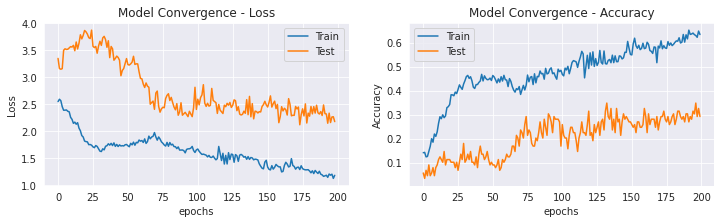

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.plot(loss_treino[1:], label='Train')
ax1.plot(loss_test[1:], label='Test')
ax1.set_title('Model Convergence - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_treino, label='Train')
ax2.plot(acc_test, label='Test')
ax2.set_title('Model Convergence - Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [22]:
def predict(nome):
  model.eval()

  tns = torch.zeros( len(nome), tam_dicionario )
  for k, letra in enumerate(nome):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1
  tns = tns.to(args['device'])

  saida = model(tns)
  topv, topi = saida.data.topk(3, 1, True)

  print(nome)
  for value, index in zip(topv[0], topi[0]):
    print('(%.2f) %s' % (value, categorias[index]))
  print('\n')
  
predict('Mota')
predict('Kamikaze')
predict('Suarez')
predict('Paschoalon')
predict('Merkel')

Mota
(-1.44) Spanish
(-1.55) Czech
(-2.09) Portuguese


Kamikaze
(-1.63) Dutch
(-1.85) English
(-1.97) Spanish


Suarez
(-0.36) Spanish
(-2.19) Portuguese
(-3.33) Polish


Paschoalon
(-0.93) Dutch
(-1.71) Spanish
(-1.80) English


Merkel
(-0.59) Scottish
(-1.68) Spanish
(-2.66) Russian




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
